In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from ipywidgets import widgets, FileUpload, Button, Output, VBox
from warnings import filterwarnings

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

#We start off by appending all the images from the directories into a list and then converting it into a NumPy array after resizing the images to 150x150.

#X_train is a list of all the images in the training set.
X_train = []
#y_train is a list of all the labels in the training set.
y_train = []
#image_size is the size of the images in the dataset.
image_size = 150

#cv2.imread() is a function in OpenCV that reads an image from a file.
#cv2.resize() is a function in OpenCV that resizes an image.
for i in labels:
    folderPath = 'C://Users//HP//Tumor//Training_1//'+ i + '/'
    for filename in os.listdir(folderPath):
        img = cv2.imread(folderPath + filename)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(labels.index(i))

for i in labels:
    folderPath = 'C://Users//HP//Tumor//Testing_1//' + i + '/'
    for filename in os.listdir(folderPath):
        img = cv2.imread(folderPath + filename)
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(labels.index(i))

X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)

(3712, 150, 150, 3)


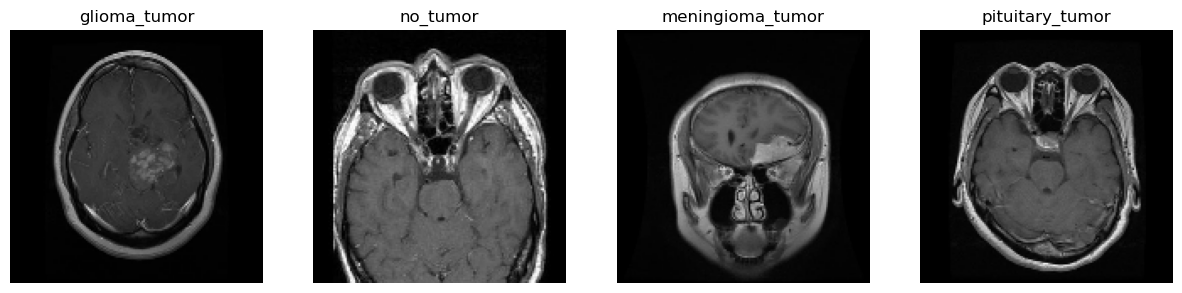

In [ ]:
label_indices = {}

# Loop through the data and find the first occurrence of each label
for idx, label in enumerate(y_train):
    if label not in label_indices:
        label_indices[label] = idx

# Create a subplot with 1 row and as many columns as there are labels
fig, ax = plt.subplots(1, len(labels), figsize=(15, 15))

# Loop through the label_indices dictionary and plot one image for each label
for label, idx in label_indices.items():
    ax[label].imshow(cv2.cvtColor(X_train[idx], cv2.COLOR_BGR2RGB))  # OpenCV loads images in BGR, convert to RGB
    ax[label].set_title(labels[label])
    ax[label].axis('off')

plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,test_size=0.1,random_state=7)

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = keras.layers.GlobalAveragePooling2D()(model) #takes the average of the numbers coming from the previous layer to simply computation
model = keras.layers.Dropout(rate=0.5)(model) #randoly drops 50% of the neurons
model = keras.layers.Dense(4, activation='softmax')(model) #output layer with 4 units and softmax activation function
model = keras.models.Model(inputs=effnet.input, outputs=model) #creates the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 38, 38, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 38, 38, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 38, 38, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 19, 19, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 19, 19, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 19, 19, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 10, 10, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 10, 10, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 10, 10, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 10, 10, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 10, 10, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 10, 10, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 10, 10, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 10, 10, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 10, 10, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 10, 10, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 10, 10, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 5, 5, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 5, 5, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 5, 5, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 5, 5, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 5, 5, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 5, 5, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 5, 5, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 5, 5, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 5, 5, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['top_activation[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 dropout (

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
#effnet.h5 is where the checkpoint will be saved
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
94/94 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8426
Epoch 1: val_accuracy improved from -inf to 0.86527, saving model to effnet.h5


C:\Users\HP\anaconda3\envs\orange\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 852s 8s/step - loss: 0.4532 - accuracy: 0.8426 - val_loss: 0.7461 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 2/5
94/94 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9428
Epoch 2: val_accuracy did not improve from 0.86527
94/94 [==============================] - 691s 7s/step - loss: 0.1764 - accuracy: 0.9428 - val_loss: 0.6311 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 3/5
94/94 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9544
Epoch 3: val_accuracy improved from 0.86527 to 0.91916, saving model to effnet.h5
94/94 [==============================] - 540s 6s/step - loss: 0.1311 - accuracy: 0.9544 - val_loss: 0.2665 - val_accuracy: 0.9192 - lr: 0.0010
Epoch 4/5
94/94 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9611
Epoch 4: val_accuracy improved from 0.91916 to 0.96108, saving model to effnet.h5
94/94 [==============================] - 424s 5s/step - loss: 0.1191 - accura

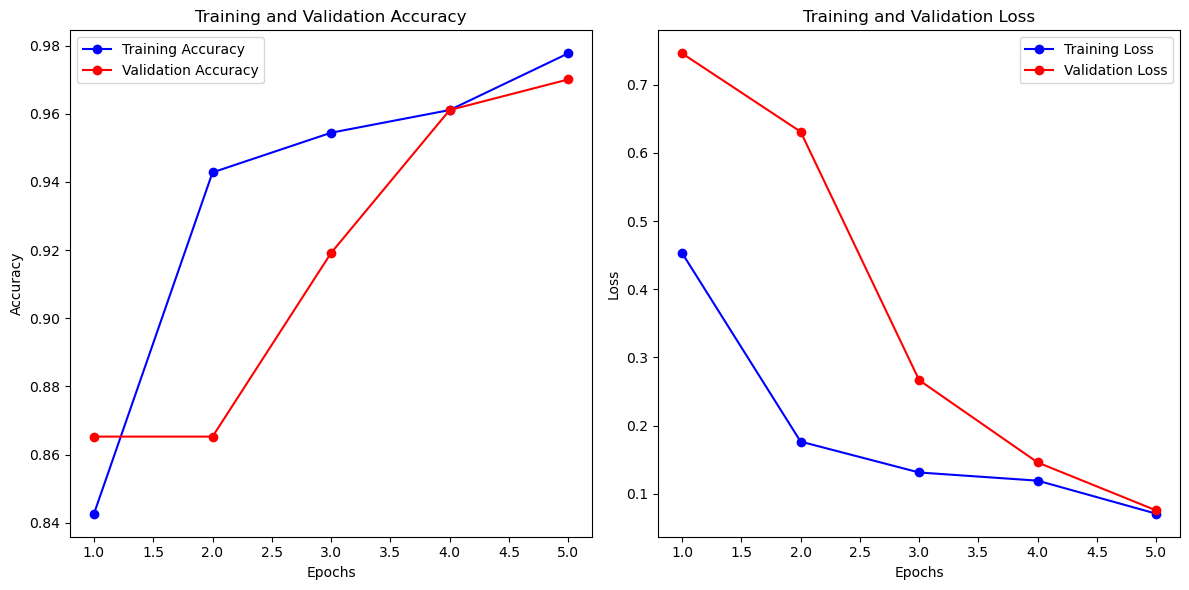

In [ ]:
history_dict = history.history

# Extract the training and validation accuracy
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

#Etract the training and validation loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_acc) + 1)

# Create a new figure
plt.figure(figsize=(12, 6))

#Subplots
plt.subplot(1, 2, 1) #1 row, 2 columns, 1st subplot
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
pred1 = model.predict(X_test)
pred = np.argmax(pred1,axis=1)
y_test_new = np.argmax(y_test,axis=1)
accuracy_effnet = accuracy_score(y_test_new, pred)
print(accuracy_effnet)

12/12 [==============================] - 11s 957ms/step
0.9623655913978495


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        98
           1       0.99      1.00      1.00       103
           2       0.93      0.94      0.94        85
           3       1.00      0.93      0.96        86

    accuracy                           0.96       372
   macro avg       0.96      0.96      0.96       372
weighted avg       0.96      0.96      0.96       372



In [ ]:
from ipywidgets import widgets, FileUpload, Button, Output, VBox
import io
from PIL import Image
import cv2
import numpy as np
from tensorflow import keras  # Importing the keras library from TensorFlow
import keras

model = keras.models.load_model('effnet.h5')


def img_pred(upload, model):
    upload_tuple = upload.value
    if isinstance(upload_tuple, tuple) and len(upload_tuple) > 0:
        upload_dict = upload_tuple[0]
        if 'content' in upload_dict:
            img_content = upload_dict['content']
            img = Image.open(io.BytesIO(img_content))
            opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
            img = cv2.resize(opencvImage, (150, 150))
            img = img.reshape(1, 150, 150, 3)
            p = model.predict(img)
            p = np.argmax(p, axis=1)[0]

            if p == 0:
                p = 'Glioma Tumor'
            elif p == 1:
                print('The model predicts that there is no tumor')
            elif p == 2:
                p = 'Meningioma Tumor'
            else:
                p = 'Pituitary Tumor'

            if p != 1:
                print(f'The Model predicts that it is a {p}')
        else:
            print("Content not found in upload")
    else:
        print("Unexpected data structure:", upload_tuple)




uploader = FileUpload()
display(uploader)

button = Button(description='Predict')
output = Output()  # Use the same name here

def on_button_clicked(_):
    with output:  # And also here
        output.clear_output()
        if uploader.value:
            # Take the first uploaded image for prediction
            img_content = uploader.value[0]['content']
            img = Image.open(io.BytesIO(img_content)).convert('RGB')
            img = img.resize((150, 150))
            img_array = np.array(img)

            plt.imshow(img_array)
            plt.axis('off')
            plt.show()
        try:
            img_pred(uploader, model)  # Pass the model as a second argument
        except Exception as e:
            print('No Image Uploaded/Invalid Image File:', str(e))

button.on_click(on_button_clicked)
display(VBox([button, output]))

FileUpload(value=(), description='Upload')